# Mini-project: Horror / non-Horror collection

We've put some effort into building our collection. Now it's time to learn something about it. You already have lots of excellent ideas for how to apply the tools we've learned about so far. It's also a good time of the semester to review what we have learned and practice applying it in less structured settings.

You will work in groups of 2-4 to do a short project applying code from the previous weeks to this collection. You will turn in a completed project as a notebook with the following sections:

1. Question(s). Describe what you wanted to learn. Suggest several possible answers or hypotheses, and describe in general terms what you might expect to see if each of these answers were true (save specific measurements for the next section). For example, many students want to know the difference between horror and non-horror, but there are many ways to operationalize this question. 

2. Methods. Describe how you will use computational methods presented so far in this class to answer your question. What do the computational tools do, and how does their output relate to your question? Describe how you process the collection into a form suitable for a model or algorithm.

3. Code. Code should be correct (no errors) and focused (unneeded code from examples is removed). Use the notebook format effectively: code may be incorporated into multiple sections.

4. Results. Use sorted lists, tables, and visual presentations to make your argument. Excellent projects will provide multiple views of results, and follow up on any apparent outliers or strange cases, including through careful reading of the original documents.

5. Reflection. Describe your experience in this process. What was harder or easier than you expected? What compromises or negotiations did you have to accept to match the collection, the question, and the methods? What would you try next? 

6. Responsibility. Describe each team member's contribution. Credit any online sources (stack overflow, blog posts, documentation) that you found helpful.

We will grade this work based on accuracy, thoroughness, creativity, reflectiveness, and quality of presentation. Scope: this is a *mini*-project, with a short deadline. We are expecting work that is consistent with that timeframe.

In [31]:
import csv, sys, os, re
import numpy as np
import spacy
from sklearn.cluster import KMeans

import collections
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from scipy import fftpack

## Question

Describe what you wanted to learn. Suggest several possible answers or hypotheses, and describe in general terms what you might expect to see if each of these answers were true (save specific measurements for the next section). For example, many students want to know the difference between horror and non-horror, but there are many ways to operationalize this question. 

We wanted to do an investigation into plot shapes, and see if we can identify clusters of documents with similar plot shapes.

## Methods

Describe how you will use computational methods presented so far in this class to answer your question. What do the computational tools do, and how does their output relate to your question? Describe how you process the collection into a form suitable for a model or algorithm.

We split each document into 100 pieces and got the sentiment of each piece. We used the lexicon file from week 3 to determine the sentiment. We plotted the results of the sentiments, and then smoothed the distribution using FFT. We then performed clustering using K-means on the sentiment scores in order to see if there were any distinct clusters formed from the list of documents.

## Code

In [37]:
word_pattern = re.compile("\w[\w\-\']*\w|\w")

documents = []

with open("../data/Gutenberg-2019-10-21/metadata.csv", encoding="utf-8") as reader:
    csv_reader = csv.DictReader(reader)
    for document in csv_reader:
        try:
            with open("../data/Gutenberg-2019-10-21/{}".format(document["Filename"]), encoding="utf-8") as reader:
                # print(document["Author"] + " / " + document["Title"])

                lines = []
                for line in reader:
                    lines.append(line.rstrip())

                text = " ".join(lines)
                document["Text"] = text
                document["Tokens"] = word_pattern.findall(text)
                
                documents.append(document)
        except Exception as e:
            pass
            # print(f'Problem with {document["Filename"]}: {e}')
print("done!")

done!


In [38]:
SECTIONS = 100
# we will now split each document into even 100 sections based on word count
split_documents = collections.defaultdict(dict)

for doc in documents:
    section_size = int(len(doc["Tokens"]) / SECTIONS)
    split_documents[doc["Title"]]["Sections"] = [doc["Tokens"][(section_size*i):(section_size*(i+1))] for i in range(SECTIONS - 1)]
    
    # special case for the last index if length isn't divisible by SECTIONS
    split_documents[doc["Title"]]["Sections"].append(doc["Tokens"][(section_size*(SECTIONS-1)):len(doc["Tokens"])])

In [39]:
# we use the sentiment lexicon from week 3

word_weights = {}
with open("../week3/bingliu.csv") as lexicon_reader:
    for line in lexicon_reader:
        weight, word = line.rstrip().split(",") ## split on comma
        word_weights[word] = float(weight) ## convert string to number

In [40]:
# helper function for getting sentiment score
def score(text):
    counter = Counter(text)
    score = 0
    for token in counter.keys():
        token = token.lower()
        if token in word_weights:
            score += counter[token] * word_weights[token]
    return score / len(counter)

In [41]:
# helper function for plotting scores
def plot_scores(scores, title):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel('Narrative Progression')
    ax.set_ylabel('Sentiment Score')
    ax.set_title(title)
    x = np.linspace(0, 100, 100)
    ax.plot(x, scores)
    plt.show()

In [71]:
# apply regular smoothing then fourier transform to smooth list of sentiment scores

def fft_smooth(scores):
    # reg smoothing
    cp = scores[:]
    for i in range(1, len(scores) - 1):
        scores[i] = (cp[i-1] + cp[i] + cp[i+1])/3
    # ft
    time_step = 0.01
    sig_fft = fftpack.fft(scores)
    power = np.abs(sig_fft)
    sample_freq = fftpack.fftfreq(len(scores), d=time_step)
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    peak_freq = freqs[power[pos_mask].argmax()]
    high_freq_fft = sig_fft.copy()
    high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
    filtered_sig = fftpack.ifft(high_freq_fft)
    return [np.real(x) for x in filtered_sig]

In [50]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "entity_linker", "textcat", "entity_ruler"])

for doc in documents:
    split_documents[doc["Title"]]["Sentiment"] = [score(sec) for sec in split_documents[doc["Title"]]["Sections"]]
    # print (doc["Title"])

There's an outlier here (see K-means clustering below): The Cask of Amontillado

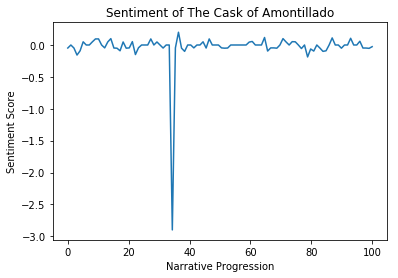

In [51]:
# plotting an outlier
s = split_documents["The Cask of Amontillado"]["Sentiment"]
plot_scores(s, "Sentiment of The Cask of Amontillado")

In [52]:
# it seems like the sharp drop is because the narrator is repeating "ugh" a lot
docinfo = split_documents["The Cask of Amontillado"]
for i in range(len(docinfo["Sentiment"])):
    if docinfo["Sentiment"][i] < -2.5:
        print(docinfo["Sections"][i])

['you', 'had', 'that', 'cough', 'Ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'ugh', 'My', 'poor', 'friend', 'found']


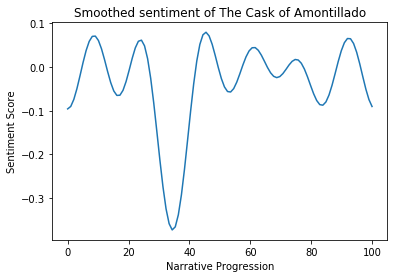

In [53]:
plot_scores(fft_smooth(s), "Smoothed sentiment of The Cask of Amontillado")

In [54]:
sentiment = np.zeros((120, 100))
smooth_sentiment = np.zeros((120, 100))
names = []
i = 0
for key in split_documents:
    sentiment[i] = split_documents[key]['Sentiment']
    smooth_sentiment[i] = fft_smooth(split_documents[key]['Sentiment'])
    names.append(key)
    i += 1

In [55]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(sentiment)
smooth_kmeans = KMeans(n_clusters=4, random_state=0).fit(smooth_sentiment)

In [56]:
U,S,Vt = np.linalg.svd(sentiment)

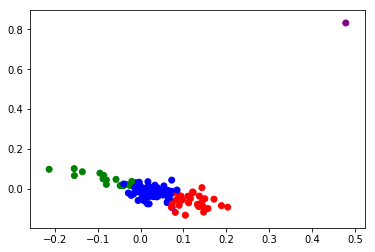

In [57]:
# quite the outlier
colormap = {0: "red", 
            1: "blue",
            2: "green", 
            3: "purple",
            4: "gray",
            5: "orange",
           }

categories = [colormap[kmeans.labels_[i]] for i in range(len(sentiment))]
plt.scatter(U[:,0], U[:,1], c=categories)
plt.show()

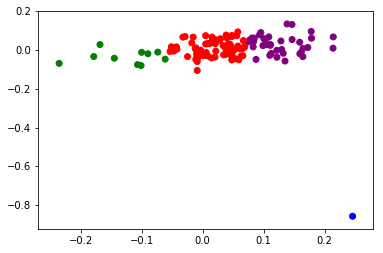

In [58]:
# the outlier exists even after smoothing
U,S,Vt = np.linalg.svd(smooth_sentiment)
colormap = {0: "red", 
            1: "blue",
            2: "green", 
            3: "purple",
            4: "gray",
            5: "orange",
           }

categories = [colormap[smooth_kmeans.labels_[i]] for i in range(len(smooth_sentiment))]
plt.scatter(U[:,0], U[:,1], c=categories)
plt.show()

## Results

This is our analysis after removing the outlier. We do K-means clustering for K=4 on the plot curves, and then plot the average plot progression of each cluster. We also investigate how big each cluster is, what texts are in each cluster, and if clusters are internally consistent.

In [59]:
del split_documents["The Cask of Amontillado"]

In [60]:
n_clusters = 4
sentiment = np.zeros((120, 100))
smooth_sentiment = np.zeros((120, 100))
names = []
i = 0
for key in split_documents:
    sentiment[i] = split_documents[key]['Sentiment']
    smooth_sentiment[i] = fft_smooth(split_documents[key]['Sentiment'])
    names.append(key)
    i += 1
    
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(sentiment)
smooth_kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(smooth_sentiment)

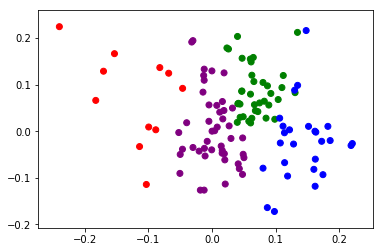

In [61]:
U,S,Vt = np.linalg.svd(sentiment)
colormap = {0: "red", 
            1: "blue",
            2: "green", 
            3: "purple",
            4: "gray",
            5: "orange",
           }

categories = [colormap[kmeans.labels_[i]] for i in range(len(sentiment))]
plt.scatter(U[:,0], U[:,1], c=categories)
plt.show()

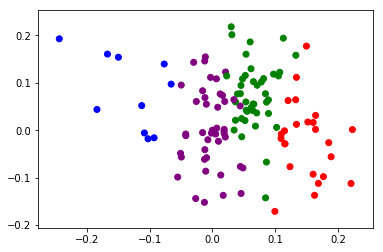

In [62]:
# these clusters don't look fantastic, but at least there isn't a ton of overlap
U,S,Vt = np.linalg.svd(smooth_sentiment)
colormap = {0: "red", 
            1: "blue",
            2: "green", 
            3: "purple",
            4: "gray",
            5: "orange",
           }

categories = [colormap[smooth_kmeans.labels_[i]] for i in range(len(smooth_sentiment))]
plt.scatter(U[:,0], U[:,1], c=categories)
plt.show()

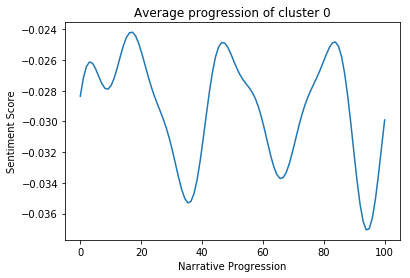

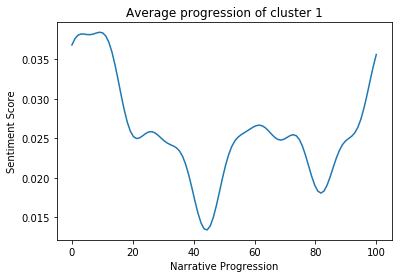

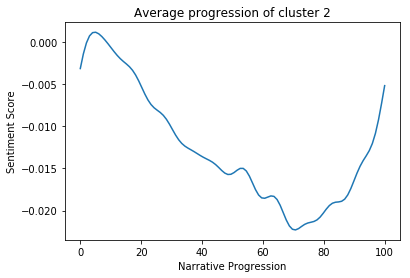

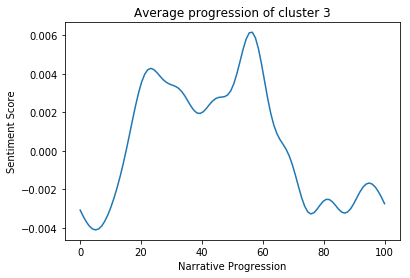

In [63]:
# plot average of each cluster
labels = list(smooth_kmeans.labels_)
for i in range(n_clusters):
    cluster_sent = np.array([smooth_sentiment[x] for x in range(len(smooth_sentiment)) if labels[x] == i])
    avg_sent = np.mean(cluster_sent, axis = 0)
    plot_scores(avg_sent, "Average progression of cluster "+str(i))
    

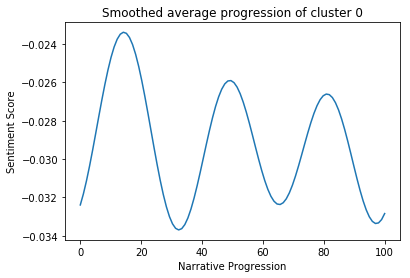

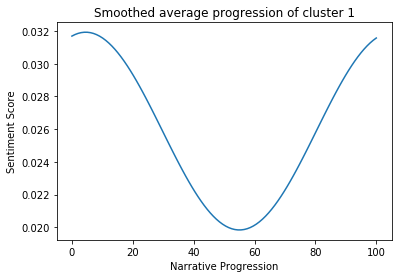

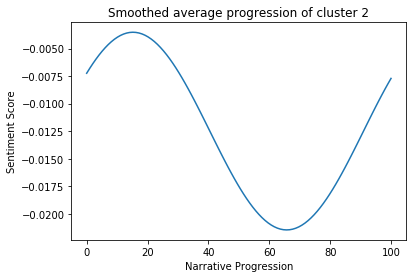

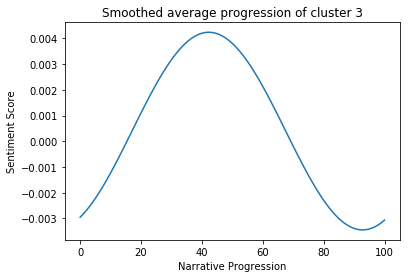

In [64]:
# plot smoothed average of each cluster
labels = list(smooth_kmeans.labels_)
for i in range(n_clusters):
    cluster_sent = np.array([smooth_sentiment[x] for x in range(len(smooth_sentiment)) if labels[x] == i])
    avg_sent = fft_smooth(list(np.mean(cluster_sent, axis = 0)))
    plot_scores(avg_sent, "Smoothed average progression of cluster "+str(i))
    

In [65]:
# plot which titles are in each cluster
cluster_titles = defaultdict(list)
for i in range(len(names)):
    cluster_titles[smooth_kmeans.labels_[i]].append(names[i])
    
for k in cluster_titles:
    print("Cluster "+str(k))
    print(cluster_titles[k], )

Cluster 1
['Emma', 'Persuasion', 'Pride and Prejudice', 'Sense and Sensibility', 'Glinda of Oz', 'A Sweet Little Maid', 'The Used People Lot', "The Mummy's Foot", 'The Lady of the Shroud', "Gulliver's Travels Into Several Remote Nations of the World"]
Cluster 3
['The Wonderful Wizard of Oz', 'Four Weird Tales', 'Jane Eyre: An Autobiography', "Bulfinch's Mythology", 'The Odyssey', "Alice's Adventures in Wonderland", 'The Secret Adversary', 'La Grande Breteche', 'A Christmas Carol', 'Great Expectations', 'The Three Musketeers', 'The Man in the Iron Mask', 'The Count of Monte Cristo', 'The Book of Wonder', 'The House of the White Shadows', 'The Markenmore Mystery', 'The Middle of Things', 'The Yellow Wallpaper', 'Kwaidan Stories and Studies of Strange Things', 'The Forest Lovers', 'Leviathan', 'The Boats of the "Glen Carrig"', 'Life Blood', 'Gengangere', 'The Legend of Sleepy Hollow', 'Ghost Story of an Antiquary', 'A Thin Ghost and Others', 'Dubliners', 'Metamorphosis', 'The Trial', 'The

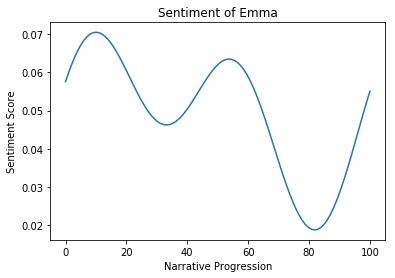

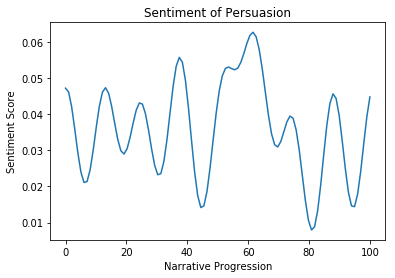

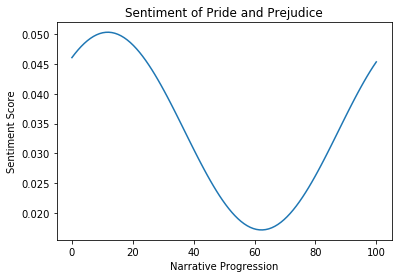

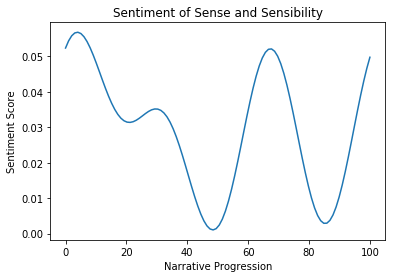

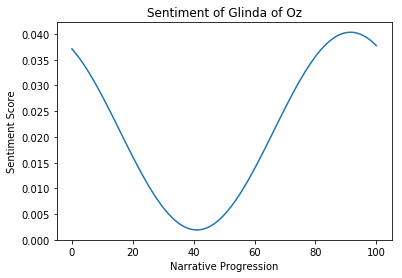

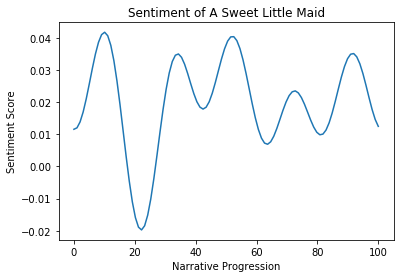

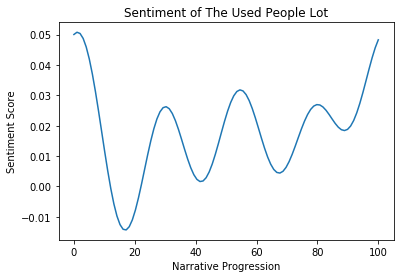

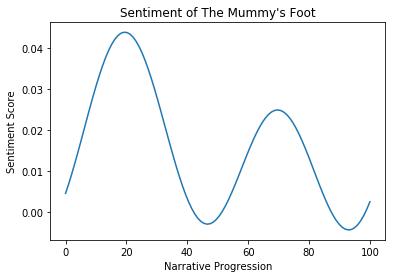

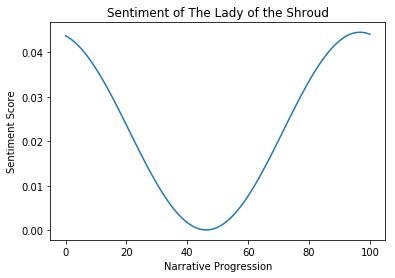

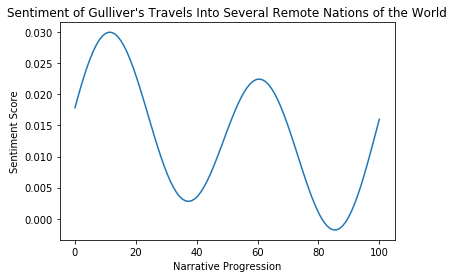

In [70]:
# plot the sentiment curves of each document in a cluster to see if they are consistent

# it seems like there is a lot of variation, but I can see how the algorithm thought they were similar.
C = 1
labels = list(smooth_kmeans.labels_)
cluster_sent = [(names[x], smooth_sentiment[x]) for x in range(len(smooth_sentiment)) if labels[x] == C]
for n,s in cluster_sent[:10]:
    plot_scores(s, "Sentiment of "+str(n))

## Reflection

Describe your experience in this process. What was harder or easier than you expected? What compromises or negotiations did you have to accept to match the collection, the question, and the methods? What would you try next? 

It was interesting that our plot curves do not match the "six plot curves" that we read in the reading. In fact, ours are much more varied and diverse especially when considering individual works as opposed to overall clusters which have to be more generalized for fit.

What was difficult was figuring out a good way to "chunk" the sections, since 1/100th of a document varies greatly from a single chapter to a single sentence, especially in the case of a long work such as `Les Miserables` vs `The Cask of Amontillado`, a short story (and thus why it was an outlier). Yet we kept this scheme since we figured it was not an interesting part of the analysis since we only ended up with a single outlier that could be removed.

What we would attempt next would be to investigate plot curves by genre, and attempt to average it over already known categories to see if there would be any noticeable trends, as we clustered by plot curves from the overall dataset. Another improvement we would attempt would be to improve the FFT, as there were some works that it did not work properly on, such as `Persuasion`, which is in the cell above, as that does not remotely resemble a sinusoidal graph. 

## Responsibility

Describe each team member's contribution. Credit any online sources (stack overflow, blog posts, documentation) that you found helpful.

FFT: http://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html

Ellen and Jill worked on the k-means clustering of the data. Danny and Eric worked on pre-processing the data, generating the sentiment, and the FFT smoothing.
